**Importing libraries and loading the dataset**
***

In [221]:
import pandas as pd
from numpy import nan
import matplotlib.pyplot as plt
import seaborn as sns

# Set matplot lib style profile to the default one
plt.style.use('default')

data = pd.read_csv('Leadzai_DS_r&s_Exercise01_netflix.csv')
data.head(4)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."


In [222]:
# Checking columns with nan's and their percentage relative to the dataset.
data.isna().sum()[data.isna().sum()>0]/data.shape[0]*100

director      29.908028
cast           9.367549
country        9.435676
date_added     0.113546
rating         0.045418
duration       0.034064
dtype: float64

**Understanding the columns meaning and significance**
***
<br>
      
+ Show_id: Unique identifier of the show, not usefull for our analysis.
+ Type: Can be either a movie or a TV Show. We are going to split our dataset on this class as it makes sense to analyse them both individually.
+ Title: Another unique identifier, we won't use it as a target for analysis.
+ Director: roughly 30% of the values are not known, we can either leave them be and not take them into account or we can assign them to Unknown
+ Cast: Same situation as the director, with a 10% not known values
+ Country: This columns is very interesting as it instructs us about the movie provenance, since there are some multicountry rows we will either encode it to single columns or to analyse the multi-country ones and group them in some fashion 
+ Date_added: Release date on NetFlix, will be decomposed in month, year and perhaps week of the year to analyse release density.
+ Release_year: We will use this column to analyse if our content is up to date or if our library is on the old side.
+ Rating: Show/movie rating, We can conduct a rating analysis on this field and see what's our top and bottom categories.
+ Duration: Contains as the name implies the duration of movies and shows, We will find out whats the ideal movie/show length based on rating.
+ Listed_id: This stores the categories associated with a show/movie, will be expanded to encoded columns since most of them have multi class
+ Description: This is just a description, some sort of NLP could be done to research the impact of a good description into a movie/show performance, but since we don't have the performance data for each show nothing will be done here, it's a drop like show_id.

<br>

**Steps in data wrangling.**
***
<br>

- Drop show_id and description
- Fill nan's in director and cast to unknowns.
- Create a column with number of countries calculated from country. I'll decide later if it will be encoded or not.
- Decompose date added into month, year and week.
- Duration, get rid of min and seasons.
- Encode listed_in category column.


In [223]:
# droping columns
data = data.drop(columns=['show_id','description'])

In [224]:
# filling nan's
data.director.fillna('Unknown', inplace=True)
data.cast.fillna('Unknown', inplace=True)

In [225]:
# creating a column with the number of countries of provenance
def count_countries(row):
    return sum(row)

data['n_countries'] = data.country.str.get_dummies(sep=', ').apply(count_countries, axis=1)

In [226]:
# converting date to date format and adding new time related columns. using the iso calendar new method as se simple dt.week eg is going to be deprecated in future versions.
data.date_added = pd.to_datetime(data.date_added)
data['added_week'] = data.date_added.dt.isocalendar().week
data['added_month'] = data.date_added.dt.month
data['added_year'] = data.date_added.dt.isocalendar().year

# Calculating the diference between release of the movie/tv show and the actual release on the platform 
data['year_diferencial'] = data.added_year-data.release_year

In [227]:
# Expanding the listed_in ceategories column
data = pd.concat([data, data.listed_in.str.get_dummies(sep=', ')], axis = 1)

In [228]:
# splitting the data
movies = data[data.type == 'Movie']
shows = data[data.type == 'TV Show']

In [229]:
def split_seasons(x):
    return x.split(' ')[0]

In [230]:
movies.duration = pd.to_numeric(movies.duration.str.replace(' min', ''))
shows.duration = pd.to_numeric(shows.duration.apply(split_seasons))

**EDA**
***
I'll plot some columns and reliations I find interesting and analysis worthy.

**Movie an TV show duration. Let's check the more usual distributions.**

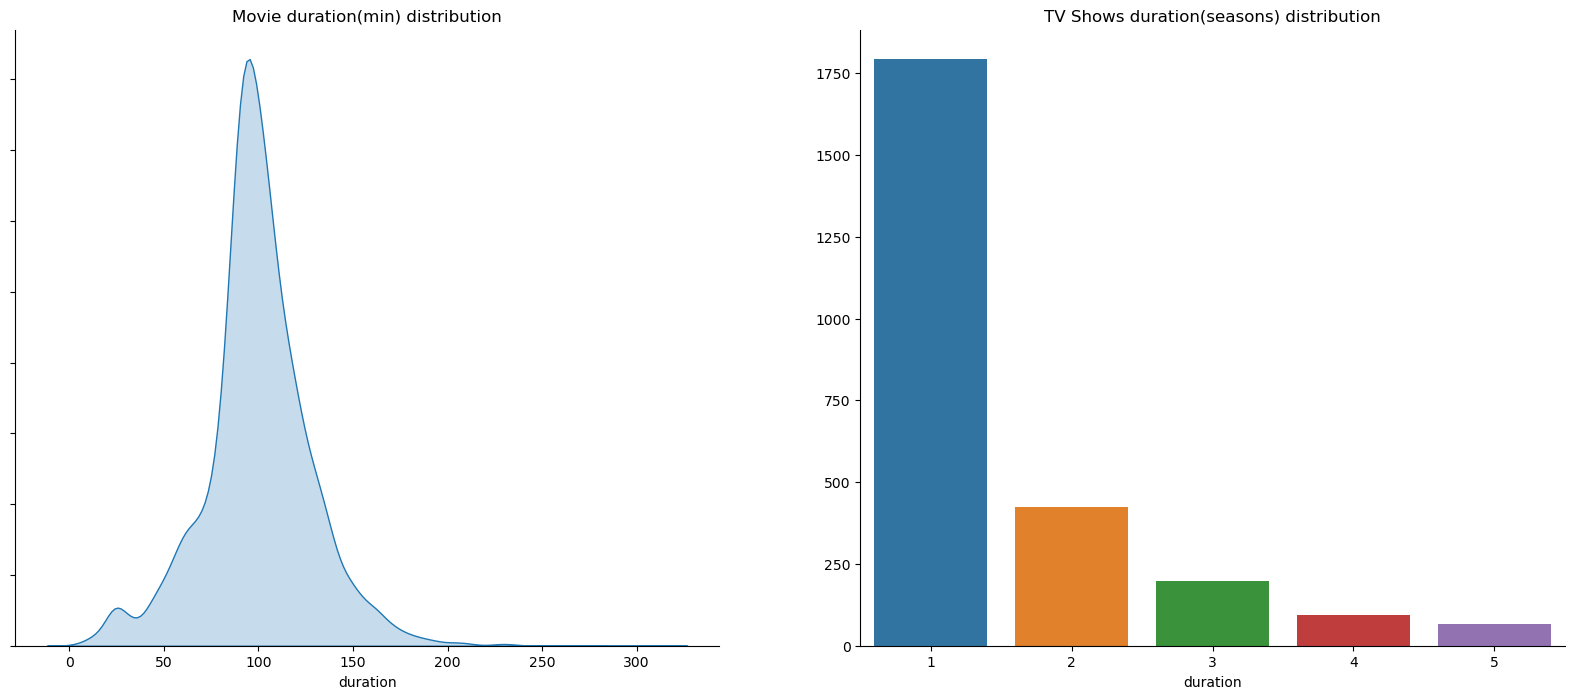

In [231]:
fig, axs = plt.subplots(1,2, figsize=(20,8))

sns.kdeplot(ax=axs[0], data=movies.duration, fill = True)
axs[0].set_title('Movie duration(min) distribution')
axs[0].set(ylabel=None, yticklabels=[])
sns.countplot(ax=axs[1], data=shows[shows.duration<6], x = 'duration')
axs[1].set_title('TV Shows duration(seasons) distribution')
axs[1].set(ylabel=None)

sns.despine()
plt.show()

<br>

- We can see that regarding movies the overall distribution tells us that the usual duration is between 60 to 140 minutes, peaking at 100 minutes. Movies outside that interval tend to be a small amount of outliers.
<br>

- Regarding TV shows we can see a high amount of a single season shows, the volume falls sharply at 2 seasons and becomes residual at values higher than three. This could indicate either that we have lots of single season series that could be either big stories that can only be told in a series or that either market analysis or quality control of many of these single series is poor. Meaning either that many of these shows shouldn't have been produced at all or that they are lacking quality.

<br>

Further exploring movies, the tendency maintains across all ratings, changing a bit in some specific categories like TV-Y wich is meant for younger spectators that is more dense in the 20 minutes duration, wich is due to a youngster attention span. Some categories like 74min, 66min and 84min are categories that just have one movie, so they are not to be taken into account.

In [232]:
import plotly.express as ff

fig = ff.histogram(movies[~movies.rating.isna()], x='duration', color='rating', width=1600, height=800, labels={"duration": "Duration"})
fig.update_layout(title_text='Movie duration(min) distribution')
fig.show()

Looking again at TV Shows, we can see that most rating categories follow the same pattern but some have higher ratios of season 2 density and above, again TV-Y and TV-Y7 for youngsters.

In [233]:
fig = ff.histogram(shows[~shows.rating.isna()], x='duration', color='rating', width=1600, height=800, labels={"duration": "Duration"})
fig.update_layout(title_text='Shows duration(min) distribution')
fig
fig.show()

***
Not every rating is represented in the TV Shows data, like stated in the pivot table bellow.
<br>
Expanding TV shows with R, PG-13 and PG ratings could prove successfull.

In [328]:
data.pivot_table(index=['rating'], columns=['type'], dropna=False, aggfunc={'type':'count'}).fillna(0)

type        
type       Movie TV Show
rating                  
66 min       1.0     0.0
74 min       1.0     0.0
84 min       1.0     0.0
G           41.0     0.0
NC-17        3.0     0.0
NR          75.0     5.0
PG         287.0     0.0
PG-13      490.0     0.0
R          797.0     2.0
TV-14     1427.0   733.0
TV-G       126.0    94.0
TV-MA     2062.0  1145.0
TV-PG      540.0   323.0
TV-Y       131.0   176.0
TV-Y7      139.0   195.0
TV-Y7-FV     5.0     1.0
UR           3.0     0.0

**Let's now analyse the top 20 country of origin for movies and TV shows**
***

In [234]:
# Unpacking the column because we have many rows that have multi countries of origin.
def unpack_country(data):
    bycountry = pd.DataFrame(data.country.str.get_dummies(sep=', ').sum()).reset_index()
    bycountry.columns = ['country','value']
    bycountry.sort_values(by='value', ascending=False, inplace=True)
    return bycountry[:20]

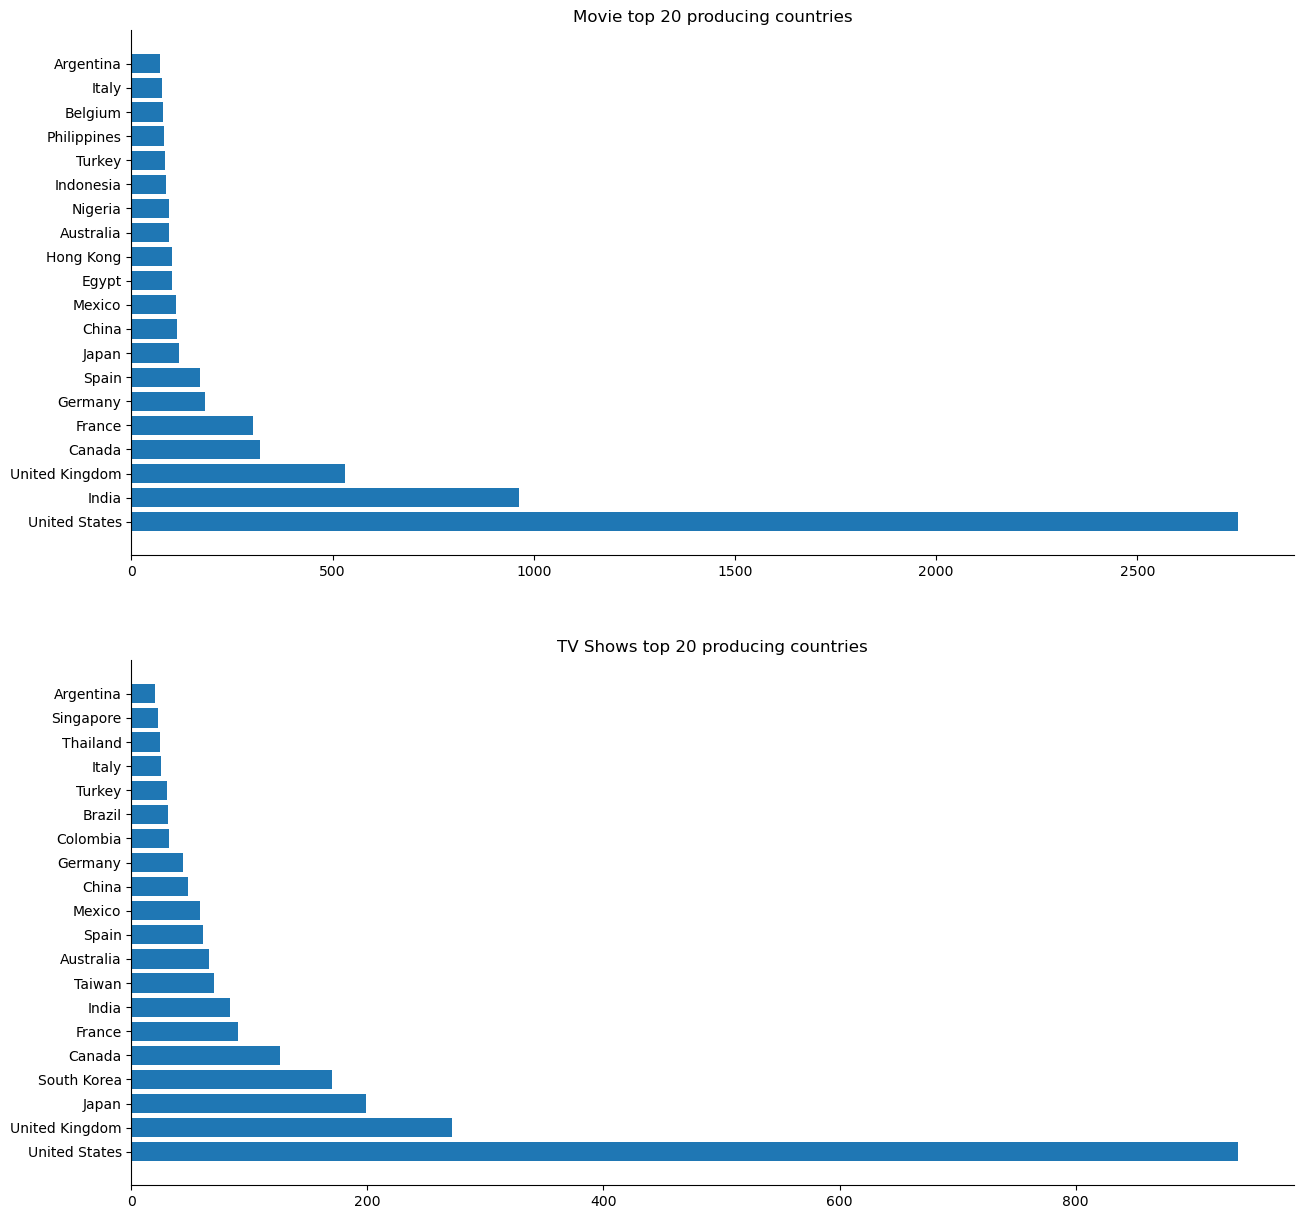

In [235]:
top20_movies = unpack_country(movies)
top20_shows = unpack_country(shows)

fig, axs = plt.subplots(2,1, figsize=(15,15))

axs[0].barh(top20_movies['country'],top20_movies['value'])
axs[0].set_title('Movie top 20 producing countries')
axs[1].barh(top20_shows['country'],top20_shows['value'])
axs[1].set_title('TV Shows top 20 producing countries')

sns.despine()
plt.show()

**Main takeaways regarding country of origin**
***
<br>

- The United States are the leading country in both categories, but we can see diferent players below for each category.
- India, as we know India is a powerhouse globaly with thei bollywood industry and that shows in the movies plot, where they are a strong 2nd contender with almost the double of the 3rd(UK), in the TV Shows it drops a lot. 
- Uk is globaly the second player, but more relevant on the TV shows.
- Japan and South Korea are not relevant regarding movies, the later doesn't even show in our movies top 20, but they come really strong in the TV Show section.
- Canada and France are also a strong players in both sections.
- Other countries represent a really small portion of the netflix library.

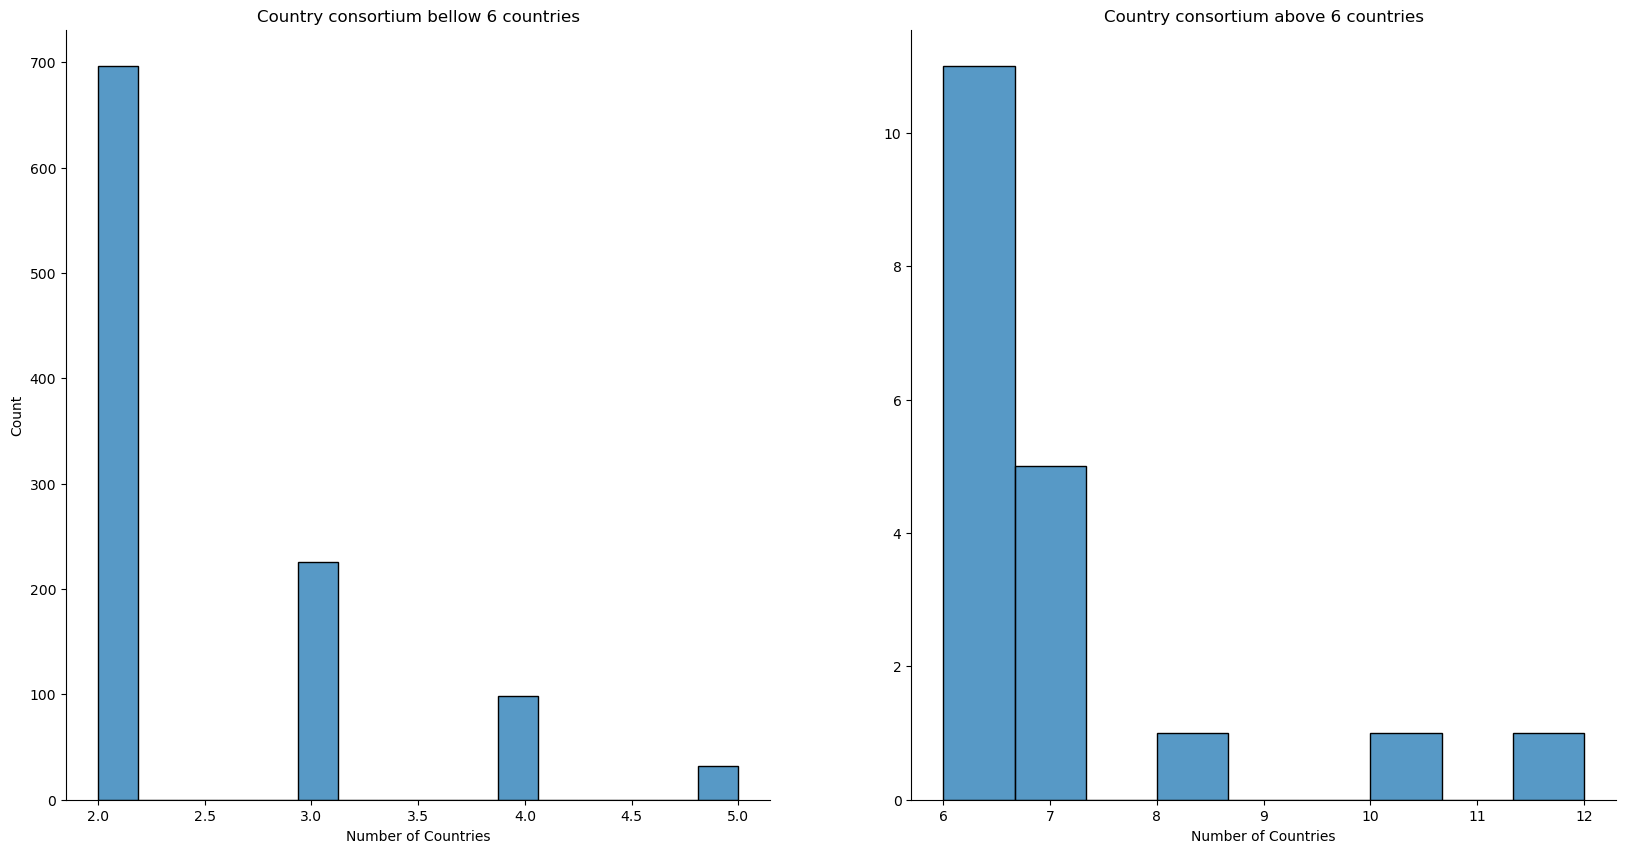

In [236]:
#Looking into multi-country titles from the whole dataset
fig, axs = plt.subplots(1,2, figsize=(20,10))

sns.histplot(ax=axs[0], data=movies.query('n_countries  < 6 & n_countries  > 1')['n_countries'])
axs[0].set_title('Country consortium bellow 6 countries')
axs[0].set(xlabel='Number of Countries')
axs[0].set(ylabel='Count')
sns.histplot(ax=axs[1], data=movies.n_countries[movies.n_countries>=6])
axs[1].set_title('Country consortium above 6 countries')
axs[1].set(xlabel='Number of Countries')
axs[1].set(ylabel=None)

sns.despine()
plt.show()

- There´s a significant number of 2 countries joint projects, 3 and 4 countries in the same project is also relevant.
- From 5 onwards it's not meaningfull, the second plot zooms into that, and as is possible to see it's completly negligible.

**Release dates analysis**
***
As a last step we will see if we have any sort of delay in releasing movies and tvshows, as well as the release dates on the platform.

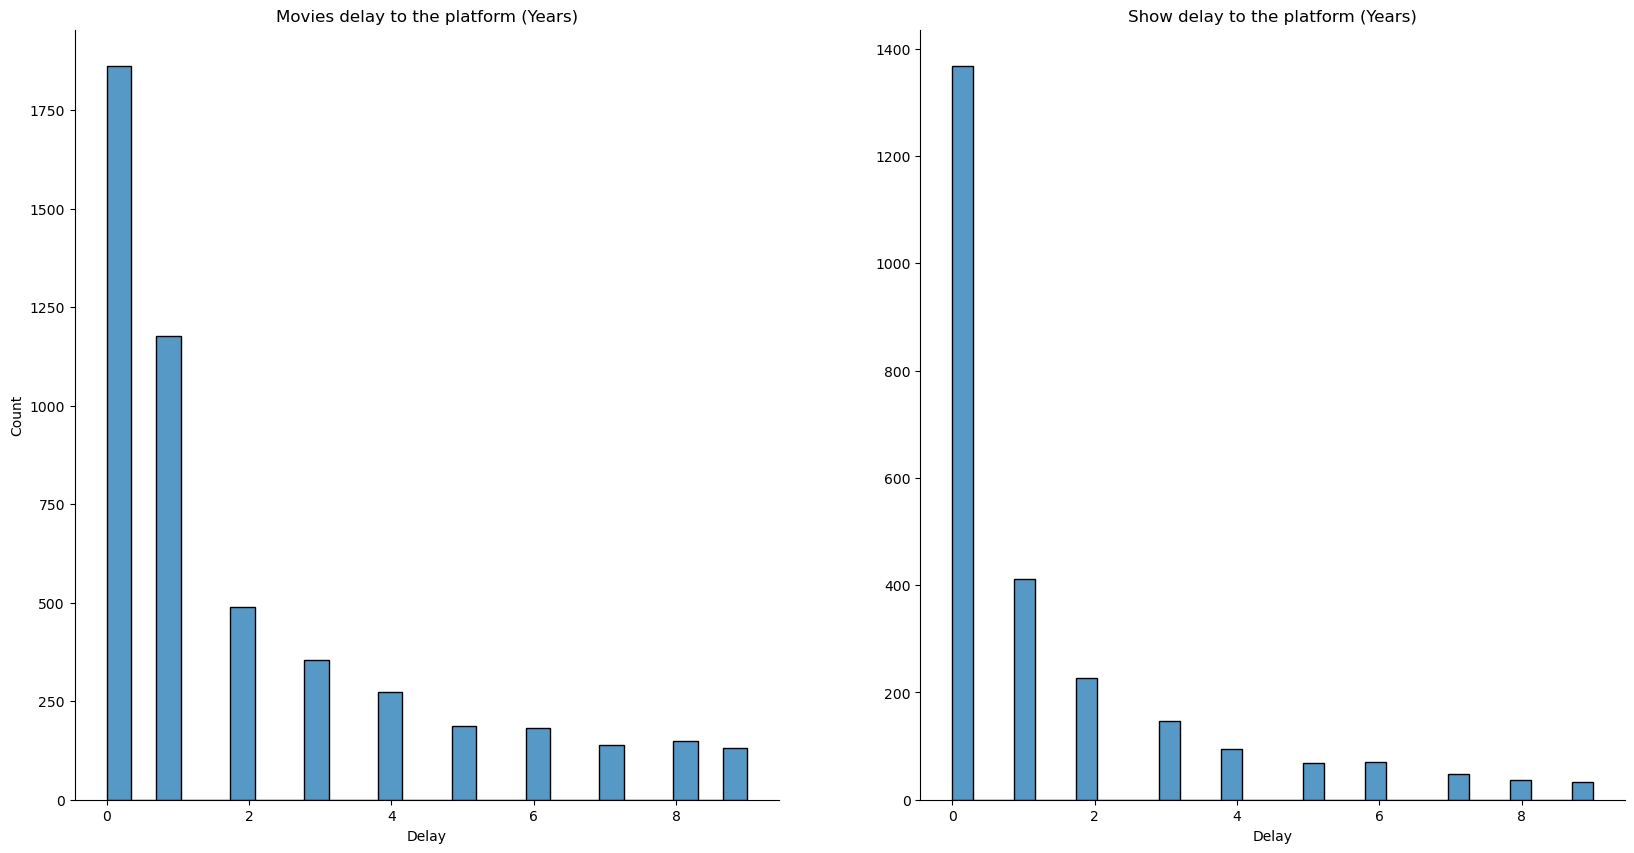

In [258]:
#Looking into multi-country titles from the whole dataset
fig, axs = plt.subplots(1,2, figsize=(20,10))

sns.histplot(ax = axs[0], data = movies[(movies.year_diferencial < 10) & (movies.year_diferencial >= 0)]['year_diferencial'])
axs[0].set_title('Movies delay to the platform (Years)')
axs[0].set(xlabel='Delay')
axs[0].set(ylabel='Count')
sns.histplot(ax = axs[1], data = shows[(shows.year_diferencial < 10) & (shows.year_diferencial >= 0)]['year_diferencial'])
axs[1].set_title('Show delay to the platform (Years)')
axs[1].set(xlabel='Delay')
axs[1].set(ylabel=None)

sns.despine()
plt.show()

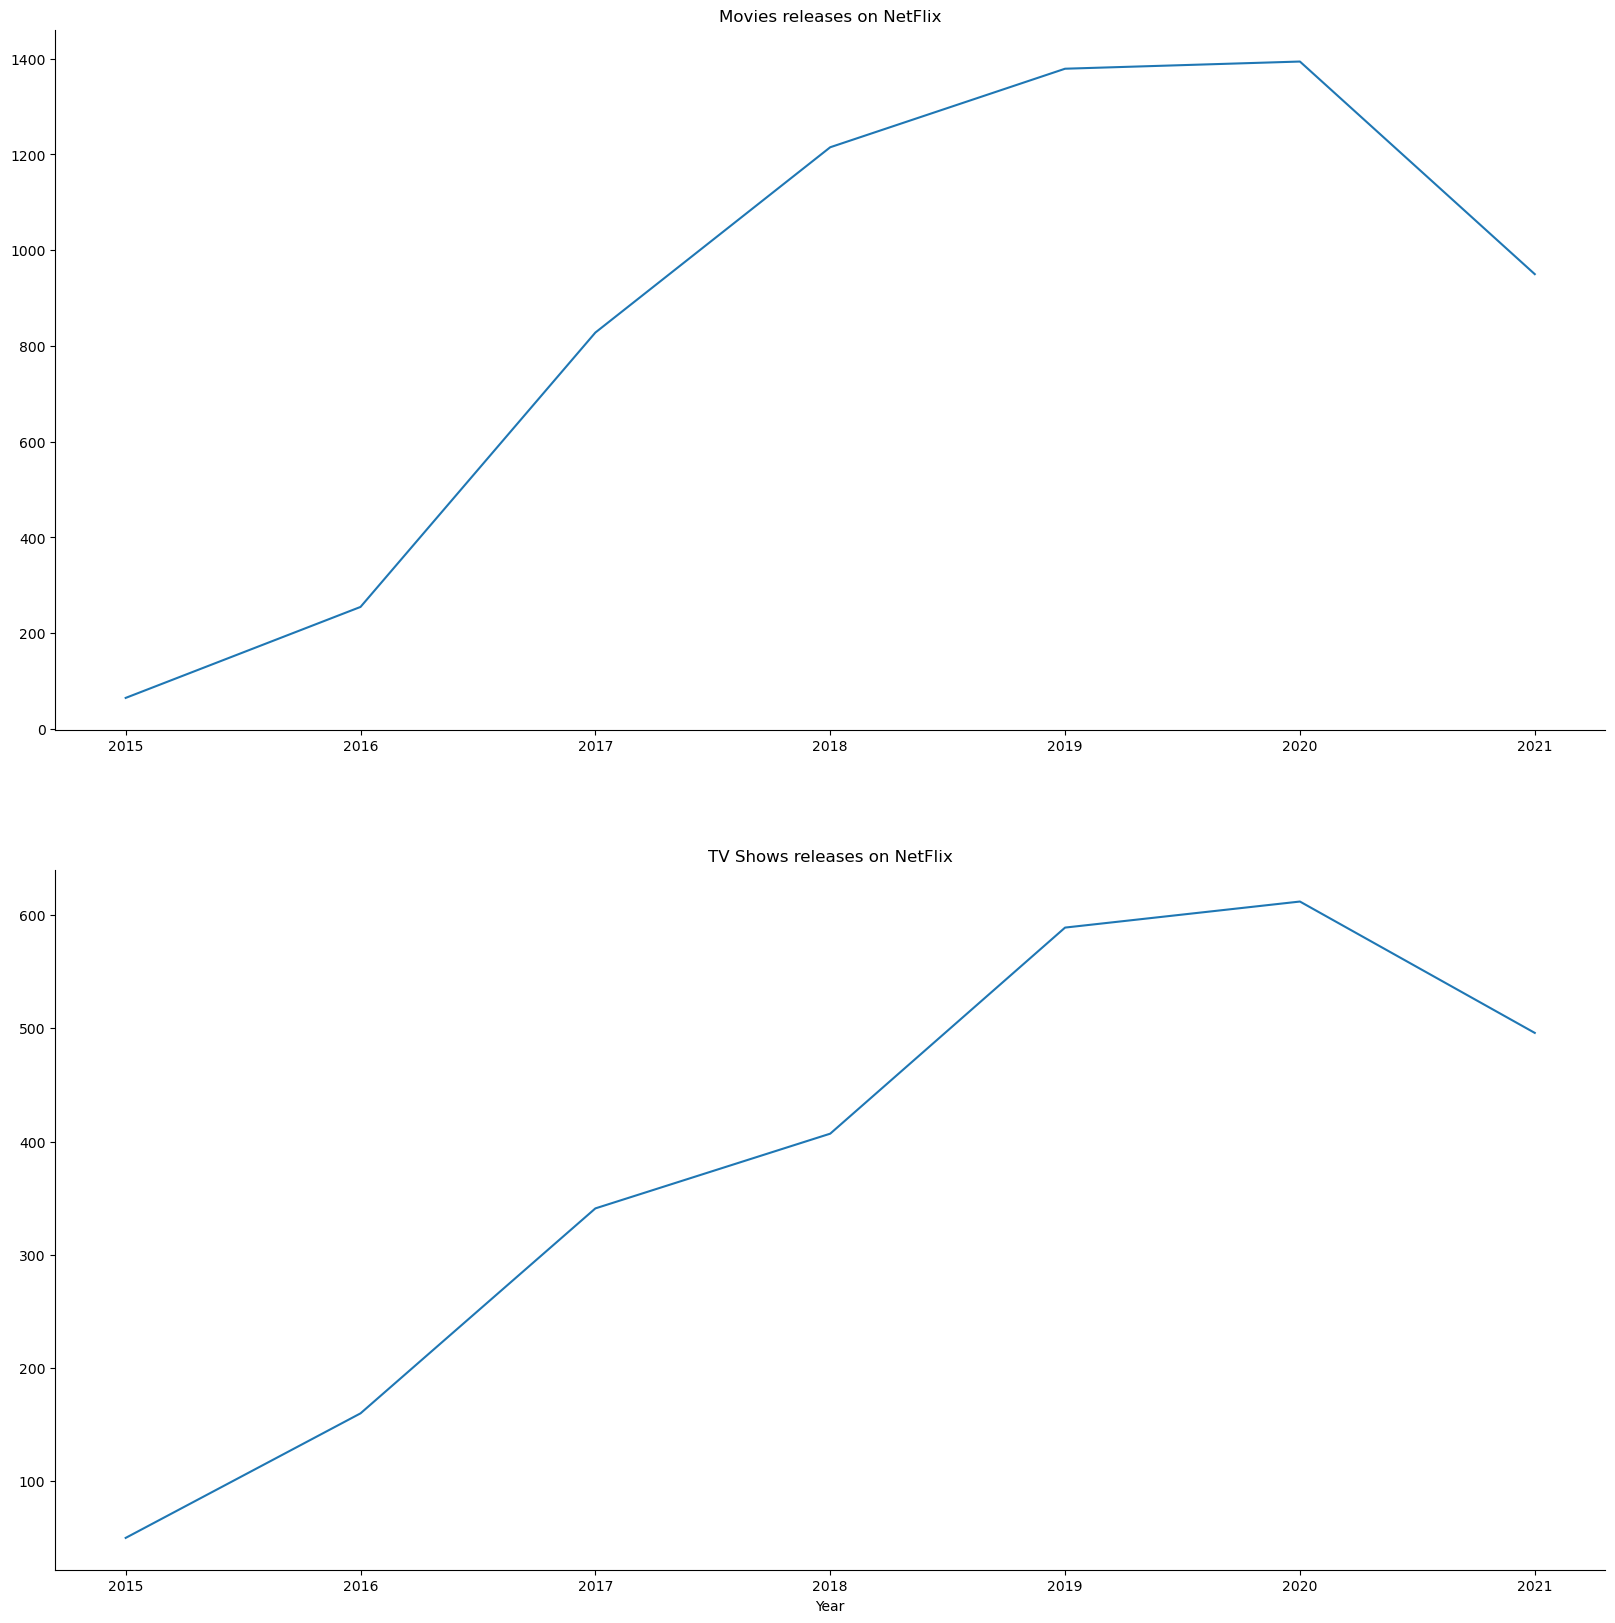

In [297]:
# Ploting releases on the platform for comparisson
fig, axs = plt.subplots(2,1, figsize=(20,20))

axs[0].plot(movies[movies.added_year>2014].groupby(by='added_year', dropna=True).agg({'added_year':'count'}))
axs[0].set_title('Movies releases on NetFlix')
axs[0].set(xlabel=None)
axs[0].set(ylabel=None)
axs[1].plot(shows[shows.added_year>2014].groupby(by='added_year', dropna=True).agg({'added_year':'count'}))
axs[1].set_title('TV Shows releases on NetFlix')
axs[1].set(xlabel='Year')
axs[1].set(ylabel=None)

sns.despine()
plt.show()

**Main takeaways on releases**
***
<br>

- We can see clearly that the number of releases until 2018 for movies was very good and scaled linearly, then it stabilized until 2020. 
- For TV shows the global tendency was pretty much the same but it scaled really good until 2019, maintaining 2019 release numbers in 2020.
- 2021 saw a big drop on releases, to values somewhere between 2017-2018
- Releases for movies are more delayed than TV Shows, by a big margin. A considerable portion of our movie releases come with a 2 to 8 year delay, turning them a bit uneffective to the platform.